In [1]:
import pandas as pd
import numpy as np
import pydot
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Base de custos médicos faturados pelo seguro de saúde
df = pd.read_csv('insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Quando a variável resposta é quantitativa

In [4]:
# Variavel resposta
df_gasto = df[['charges']]

In [5]:
# Variavel preditivas
df_var = df[['age','sex','bmi','children','smoker','region']]

In [6]:
# Separando as variaveis preditivas entre categoricas e numericas
df_var_categ = df_var[['sex','smoker','region']]
df_var_int = df_var[['age','bmi','children']]

#### Relação quanti-quanti

In [7]:
df_var_int_rel = df_var_int.copy()
df_var_int_rel['charges'] = df_gasto[['charges']]

In [8]:
df_var_int_rel.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


* Correlação de sperman entre as variaveis quantitativas
    * Medida não paramétrica de dependência, mensura quando o valor de uma variável aumenta ou diminui, o valor da outra variável igualmente aumenta ou diminui
    * Observa-se que a variável idade e gastos possuem a maior correlação

In [9]:
df_var_int_rel.corr('spearman')

,age,bmi,children,charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
charges,0.534392,0.119396,0.133339,1.000000


* Plotando a relação de idade e gastos
    * Observa-se 3 grandes concentrações de dados, e, nestas, quanto maior a idade, maior a tendencia do gasto

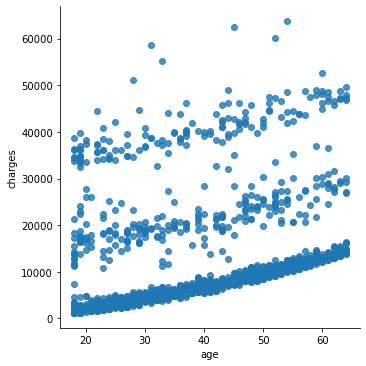

In [10]:
sns.lmplot( x="age", y="charges", data=df_var_int_rel, fit_reg=False)

* Calculando a informação mutua entre as variáveis
    * Mensura a dependência entre as variáveis
    * Quanto maior seu valor, mais forte é a relação, ou seja, menor a incerteza do valor de uma variável quando há o conhecimento da outra
    * Novamente, idade e gastos são as mais dependentes

In [11]:
from sklearn.feature_selection import mutual_info_regression

In [12]:
info = mutual_info_regression(df_var_int, df_gasto)
for x,y in zip(df_var_int.columns.tolist(),info):
    print(x,y)

age 1.501488154576315
bmi 0.07287280384749373
children 0.1608335311847484


* Para o calculo, utiliza-se o metodo de K-vizinhos, sendo este um parametro que pode ser ajustado (n_neighbors)

In [13]:
for a in range(3,6):
    info = mutual_info_regression(df_var_int, df_gasto,n_neighbors=a)
    for x,y in zip(df_var_int.columns.tolist(),info):
        print(f'{a} vizinhos p/ metodo',x,y)

3 vizinhos p/ metodo age 1.4964679138265073
3 vizinhos p/ metodo bmi 0.07251331996268107
3 vizinhos p/ metodo children 0.16141918959418833
4 vizinhos p/ metodo age 1.3868649190200792
4 vizinhos p/ metodo bmi 0.10335792453262815
4 vizinhos p/ metodo children 0.1398149949258567
5 vizinhos p/ metodo age 1.3240255490857216
5 vizinhos p/ metodo bmi 0.10287409011217541
5 vizinhos p/ metodo children 0.12705322302458644


#### Relação quali-quanti

In [14]:
df_var_categ_rel = df_var_categ.copy()
df_var_categ_rel['charges'] = df_gasto[['charges']]

In [15]:
df_var_categ_rel.head()

,sex,smoker,region,charges
0,female,yes,southwest,16884.92400
1,male,no,southeast,1725.55230
2,male,no,southeast,4449.46200
3,male,no,northwest,21984.47061
4,male,no,northwest,3866.85520


* Calcular R2 entre as variáveis quali e a variavel resposta
    * Mensura o quanto da variabilidade da variavel quanti conseguimos reduzir com a segmentação da variavel quali
    * Há relação entre ser fumante e os gastos

In [16]:
#Cria lista de variaveis qualitativas e quantitativas
CATVAR = df_var_categ_rel.select_dtypes(include=['object']).columns.tolist()
NUMVAR = df_var_categ_rel.select_dtypes(include=['float64','int64']).columns.tolist()

In [17]:
CATVAR

['sex', 'smoker', 'region']

In [18]:
NUMVAR

['charges']

In [19]:
r2 = pd.DataFrame(columns=['VarQuanti','VarQuali','var*n / n_total','R2'])
for z in NUMVAR:
    for x in CATVAR:
        dfr = df[x].value_counts().reset_index()
        f = 0
        a1 = 0
        for y in range(len(dfr)):
            a = dfr.iloc[y,1]
            a1 = a1 + a
            c = (df[df[x] == dfr.iloc[y,0]])
            e = (c[z].var())*a
            f = f + e
        f = f/a1
        r2_calc = 1 - (f/df[z].var())
        r2 = r2.append({'VarQuanti' : z, 'VarQuali' : x,'var*n / n_total' : f, 'R2' : r2_calc}, ignore_index=True)
r2 = r2.sort_values(by = 'R2', ascending = False)
r2

,VarQuanti,VarQuali,var*n / n_total,R2
1,charges,smoker,5.584712e+07,0.619187
2,charges,region,1.460026e+08,0.004431
0,charges,sex,1.462801e+08,0.002539


* Plotando a relação entre gastos e ser fumante
    * Observa-se a distinção entre a disposição das caixas do boxplot

<AxesSubplot:xlabel='smoker', ylabel='charges'>

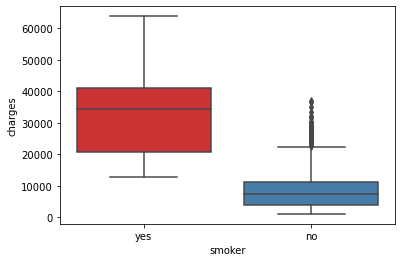

In [20]:
sns.boxplot(x="smoker", y="charges", data=df_var_categ_rel, palette="Set1")

* Ja para a baixa relação, como região e gastos, por exemplo, observa-se que as caixas estão muito proximas

<AxesSubplot:xlabel='region', ylabel='charges'>

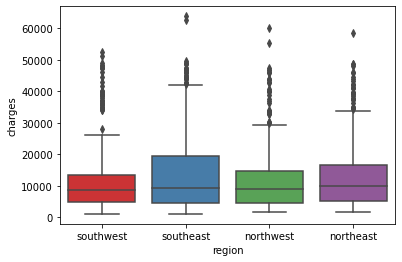

In [21]:
sns.boxplot(x="region", y="charges", data=df_var_categ_rel, palette="Set1")

* Verificando o coeficiente das variáveis por meio de uma Regressão Lasso

In [22]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [23]:
X = df[['age','sex','bmi','children','smoker','region']]
Y = df[['charges']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [25]:
#Escalar variáveis quanti
from sklearn.preprocessing import RobustScaler
colunas = ['age','bmi','children']
escaladas = {}
X_train_escal = X_train.copy()
X_test_escal = X_test.copy()
for col in colunas:
    scaler = RobustScaler()
    scaler.fit(X_train_escal[[col]])
    X_train_escal.loc[:,col] = scaler.transform(X_train_escal[[col]])
    X_test_escal.loc[:,col] = scaler.transform(X_test_escal[[col]])
    escaladas[col] = scaler

In [26]:
X_train_escal_onehot = X_train_escal.copy()
X_test_escal_onehot = X_test_escal.copy()

In [27]:
# Realizando enconding nas variaveis quali
for x in ['sex','smoker','region']:
    X_train_escal_onehot = pd.get_dummies(X_train_escal_onehot,columns=[x])
    X_test_escal_onehot = pd.get_dummies(X_test_escal_onehot,columns=[x])

In [28]:
X_train_escal_onehot.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1163,-0.88,-0.248810,-0.5,1,0,1,0,1,0,0,0
196,-0.04,0.297024,-0.5,1,0,1,0,0,0,0,1
438,0.48,1.957738,2.0,1,0,1,0,0,0,1,0
183,0.16,-0.463690,-0.5,1,0,1,0,0,1,0,0
1298,-0.28,-0.339286,0.5,0,1,1,0,0,1,0,0


In [29]:
# dropando uma coluna de cada variavel categorica, mantendo esta como referencia
X_train_escal_onehot_2 = X_train_escal_onehot.drop(['sex_male','smoker_no','region_northeast'],axis=1)
X_test_escal_onehot_2 = X_test_escal_onehot.drop(['sex_male','smoker_no','region_northeast'],axis=1)

In [30]:
# Rodando o modelo
parametro = {'alpha':[0.0001,0.001,0.01,0.1,0.5,1,5,10,15]}
scoring = {'R2': 'r2', 'Erro Quadrado médio': 'neg_mean_squared_error'}
lasso = GridSearchCV(Lasso(max_iter=100000,random_state=0), parametro, scoring = scoring, refit = 'Erro Quadrado médio', 
                     cv=10)
lasso.fit(X_train_escal_onehot_2,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=100000, normalize=False, positive=False,
                             precompute=False, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10,
                                   15]},
             pre_dispatch='2*n_jobs', refit='Erro Quadrado médio',
             return_train_score=False,
             scoring={'Erro Quadrado médio': 'neg_mean_squared_error',
                      'R2': 'r2'},
             verbose=0)

In [31]:
# melhores hiperparametros
print(lasso.best_estimator_.alpha)
print(lasso.best_score_)

5
-38779618.845152125


* Pelos coeficientes, observa-se:
    * Ser fumante e idade estão positivamente relacionados com gastos, sendo as principais relaçoes
    * Em sequência, a variável BMI é a mais significativa em elevação dos gastos

In [32]:
lasso = Lasso(alpha = 5,max_iter=100000,random_state=0)
lasso.fit(X_train_escal_onehot_2,y_train)
for x,y in zip(X_train_escal_onehot_2.columns,lasso.coef_):
    print(x,y)

age 6398.47562645461
bmi 2800.4201265667243
children 931.5573748403658
sex_female 24.35069722125687
smoker_yes 23402.121909596342
region_northwest -475.1355635637591
region_southeast -901.1859719193296
region_southwest -712.0709905607047


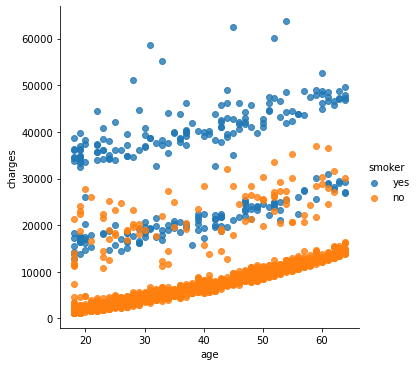

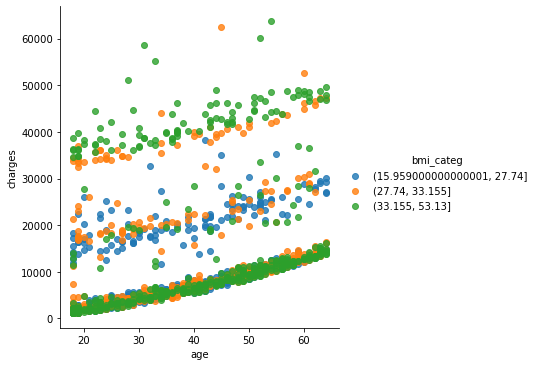

In [33]:
# Plotando as principais relações final identificada, idade, fumante e BMI, em relacao aos gastos
df['bmi_categ'] = pd.qcut(df['bmi'],3)
sns.lmplot(x="age", y="charges", hue='smoker' ,data=df, fit_reg=False)
sns.lmplot(x="age", y="charges", hue='bmi_categ' ,data=df, fit_reg=False)
plt.show() 

## Variável resposta qualitativa

* Categorizando a variável de gastos
    * Utiliza-se a opção de identificar clusters de valores, em regiões mais densas
    * Pelo silhoutte score, a melhor métrica é com 02 clusters, porém, para esta exploração, escolhe-se 04 clusters, que é a segunda maior métrica

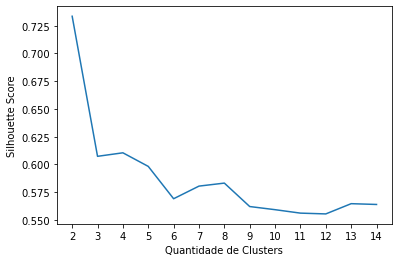

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#Calcula-se os silhoutte scores para diferentes número de clusters
silhouette_scores = []
for x in range(2, 15):
    kmeans = KMeans(init = 'k-means++',n_init = 500,max_iter = 7000,n_clusters=x,random_state=50)
    kmeans.fit(df_gasto)
    score = silhouette_score(df_gasto, kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(range(2, 15), silhouette_scores)
plt.xticks(range(2, 15))
plt.xlabel("Quantidade de Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [35]:
kmeans = KMeans(init = 'k-means++',n_init = 500,max_iter = 7000,n_clusters=4, random_state=50).fit(df_gasto)
df_gasto['clusters'] = kmeans.labels_
df_gasto.groupby('clusters').charges.agg(['count','min','max']) #verificar tamanho e limites do cluster

,count,min,max
clusters,,,
0,564,1121.87390,7749.15640
1,155,32108.66282,63770.42801
2,176,17043.34140,31620.00106
3,443,7789.63500,16884.92400


In [36]:
# Criando as categorias definidas pelos clusters
categorias = [1100,7750,17000,32000,64000]
nome_categorias = ['A - 1,1k até 7,7k', 'B - 7,7k até 17k', 'C - 17k até 32k', 'D - 32k até 64k']
df_gasto['charges_categ'] = pd.cut(df_gasto['charges'],categorias,labels = nome_categorias)

In [37]:
df_gasto['charges_categ'].value_counts()

A - 1,1k até 7,7k    564
B - 7,7k até 17k     443
C - 17k até 32k      176
D - 32k até 64k      155
Name: charges_categ, dtype: int64

#### Relação quali-quali

In [38]:
df_var_categ['charges_categ'] = df_gasto[['charges_categ']]
df_var_categ['coluna_contagem'] = 1

In [39]:
df_var_categ.head()

,sex,smoker,region,charges_categ,coluna_contagem
0,female,yes,southwest,"B - 7,7k até 17k",1
1,male,no,southeast,"A - 1,1k até 7,7k",1
2,male,no,southeast,"A - 1,1k até 7,7k",1
3,male,no,northwest,C - 17k até 32k,1
4,male,no,northwest,"A - 1,1k até 7,7k",1


* Calculando o v-cramer (medida baseada no qui-quadrado) entre as variáveis quali
    * Mensura a dependência/relação entre as variaveis
    * Observa-se que ser fumante e as categorias de gastos são as mais relacionadas

In [40]:
from scipy.stats import chi2_contingency
CATVAR = ['sex','smoker','region','charges_categ']
chimap = pd.DataFrame(columns=['Var1','Var2','xsq','pvalue','vcramer']) 
for x in CATVAR:
    for y in CATVAR:
        if x != y:
            chi = df_var_categ.pivot_table('coluna_contagem',index= [x],columns= [y] ,aggfunc = 'count')
            chi=chi.replace(np.nan,0)
            xsq,pvalue,dof,expected=chi2_contingency(chi)
            a = min(len(df_var_categ[x].unique()),len(df_var_categ[y].unique()))
            b = len(df_var_categ[x])
            vcramer = (xsq/(b*(a-1)))**(1/2)
            chimap = chimap.append({'Var1' : x, 'Var2' : y, 'xsq': xsq, 'pvalue': pvalue, 'vcramer':vcramer}, ignore_index=True)
chimap = chimap.sort_values(by = 'vcramer', ascending = False)
chimap

,Var1,Var2,xsq,pvalue,vcramer
5,smoker,charges_categ,916.546177,2.280430e-198,0.827655
10,charges_categ,smoker,916.546177,2.280430e-198,0.827655
2,sex,charges_categ,13.584676,3.528616e-03,0.100762
9,charges_categ,sex,13.584676,3.528616e-03,0.100762
8,region,charges_categ,27.238199,1.277311e-03,0.082376
11,charges_categ,region,27.238199,1.277311e-03,0.082376
0,sex,smoker,7.392911,6.548144e-03,0.074333
3,smoker,sex,7.392911,6.548144e-03,0.074333
4,smoker,region,7.343478,6.171955e-02,0.074084
7,region,smoker,7.343478,6.171955e-02,0.074084


In [41]:
freq = pd.crosstab(df_var_categ['smoker'], df_var_categ['charges_categ']).apply(lambda r: r/r.sum()*100, axis=1)
freq

charges_categ,"A - 1,1k até 7,7k","B - 7,7k até 17k",C - 17k até 32k,D - 32k até 64k
smoker,,,,
no,53.007519,39.567669,6.954887,0.469925
yes,0.000000,8.029197,37.226277,54.744526


* Plotando as relações
    * Observa-se que as categorias de maior gasto, vermelho e verde, possuem as maiores frequencias relativas na categoria de fumante

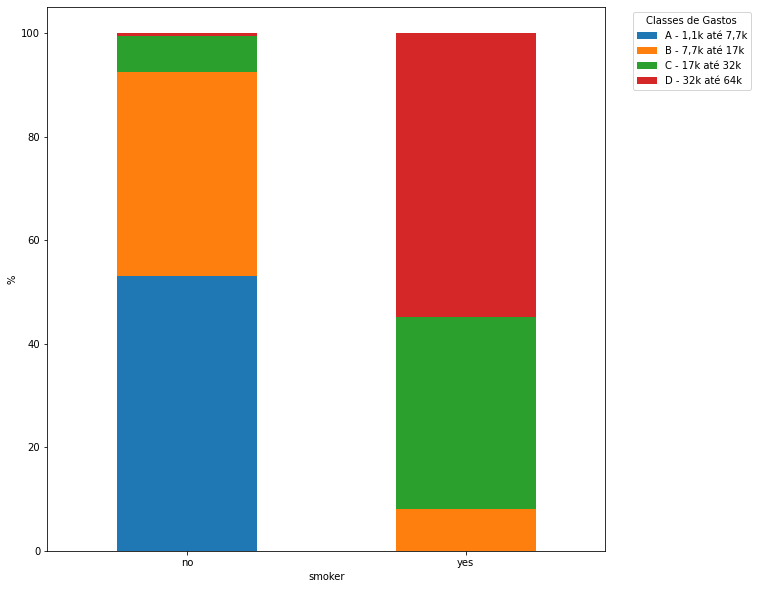

In [42]:
ax_1 = freq.plot.bar(figsize=(10,10),stacked=True, rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Classes de Gastos")
plt.xlabel('smoker')
plt.ylabel('%')
plt.show()

#### Relação quanti-quali

In [43]:
df_var_int_2 = df_var_int.copy()
df_var_int_2['charges_categ'] = df_gasto[['charges_categ']]

In [44]:
df_var_int_2.head()

,age,bmi,children,charges_categ
0,19,27.900,0,"B - 7,7k até 17k"
1,18,33.770,1,"A - 1,1k até 7,7k"
2,28,33.000,3,"A - 1,1k até 7,7k"
3,33,22.705,0,C - 17k até 32k
4,32,28.880,0,"A - 1,1k até 7,7k"


In [45]:
#Cria lista de variaveis qualitativas e quantitativas
CATVAR = df_var_int_2.select_dtypes(include=['object']).columns.tolist()
NUMVAR = df_var_int_2.select_dtypes(include=['float64','int64']).columns.tolist()

* Calculando o R2
    * A maior relação é com a variavel de idade

In [46]:
# Calculando o R2
r2 = pd.DataFrame(columns=['VarQuanti','VarQuali','var*n / n_total','R2'])
for z in NUMVAR:
    for x in CATVAR:
        dfr = df_var_int_2[x].value_counts().reset_index()
        f = 0
        a1 = 0
        for y in range(len(dfr)):
            a = dfr.iloc[y,1]
            a1 = a1 + a
            c = (df_var_int_2[df_var_int_2[x] == dfr.iloc[y,0]])
            e = (c[z].var())*a
            f = f + e
        f = f/a1
        r2_calc = 1 - (f/df[z].var())
        r2 = r2.append({'VarQuanti' : z, 'VarQuali' : x,'var*n / n_total' : f, 'R2' : r2_calc}, ignore_index=True)
r2 = r2.sort_values(by = 'R2', ascending = False)
r2

,VarQuanti,VarQuali,var*n / n_total,R2
0,age,charges_categ,110.453594,0.440462
1,bmi,charges_categ,34.060277,0.084103
2,children,charges_categ,1.450310,0.001998


* Plotando a relação
    * Observa-se que, principalmente, os valores mais baixos de gasto sao de menores idades, e a segunda faixa mais baixa possuem as maiores idades
    * As duas maiores faixas de gastos possuem alta dispersão na idade, sendo influenciado por outras variaveis

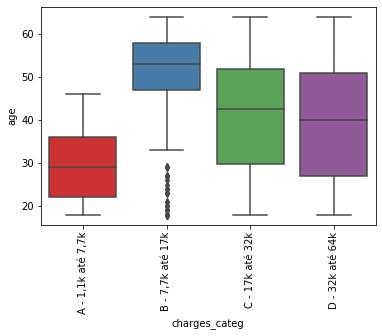

In [47]:
sns.boxplot(x="charges_categ", y="age", 
            order=["A - 1,1k até 7,7k","B - 7,7k até 17k","C - 17k até 32k","D - 32k até 64k"]
            ,data=df_var_int_2, palette="Set1")
plt.xticks(rotation=90)
plt.show()

* Verificando a importância de variável pelo modelo de árvore

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
df_gasto2 = df_gasto[['charges_categ']]
df_var = df[['age','sex','bmi','children','smoker','region']]

In [50]:
df_gasto2['charges_categ_'] = df_gasto2.charges_categ.cat.codes

In [51]:
df_gasto2.head()

,charges_categ,charges_categ_
0,"B - 7,7k até 17k",1
1,"A - 1,1k até 7,7k",0
2,"A - 1,1k até 7,7k",0
3,C - 17k até 32k,2
4,"A - 1,1k até 7,7k",0


In [52]:
df_gasto2.drop('charges_categ', axis=1, inplace=True)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_var,df_gasto2, test_size=0.30, random_state=65)

In [54]:
for x in ['sex','smoker','region']:
    X_train = pd.get_dummies(X_train,columns=[x])
    X_test = pd.get_dummies(X_test,columns=[x])

In [55]:
# Configurando os hiperparametros da Random Forest
parametros = {'max_leaf_nodes': [4,8,16,32,64], 'criterion': ['gini','entropy'], 'max_features' : [2,3]}
rf = GridSearchCV(
    RandomForestClassifier(n_estimators=3000, random_state=61658),
    parametros,
    scoring = 'roc_auc_ovr_weighted',
    cv=10)
rf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=3000, n_jobs=None,
                                              oob_score=False,
                                              ran

In [56]:
# Verificando os melhores hiperparametros e o ROC AUC no treino
print(rf.best_params_)
print(rf.best_score_)

{'criterion': 'entropy', 'max_features': 3, 'max_leaf_nodes': 64}
0.9440522070258712


In [57]:
# Calculo do ROC AUC Score nos dados de teste
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, rf.predict_proba(X_test), average='weighted', multi_class='ovr'))

0.9228013069768627


* Identificando a importancia de variaveis
    * Idade é a principal
    * Ser fumante e BMI são as secundárias

In [58]:
imps = rf.best_estimator_.feature_importances_
cols = X_train.columns
order= np.argsort(imps)[::-1]

for col,imp in zip(cols[order],imps[order]):
    print(f'{col:50s} {imp:.4f}')

age                                                0.3889
smoker_yes                                         0.1830
smoker_no                                          0.1821
bmi                                                0.1537
children                                           0.0428
region_southeast                                   0.0098
region_northeast                                   0.0088
sex_male                                           0.0082
region_southwest                                   0.0080
sex_female                                         0.0079
region_northwest                                   0.0068
